<a href="https://colab.research.google.com/github/Consolucas/ChallengeAlura_TelecomX/blob/main/ChallengeAlura_TelecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ETL

Extract

In [ ]:
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
response = requests.get(url)
data = response.json()

In [ ]:
df = pd.json_normalize(data, sep='_')

In [ ]:
df.set_index('customerID', inplace=True)
df.index.rename('clienteID', inplace=True)

In [ ]:
df

In [ ]:
df.info()

Transform

In [ ]:
df['account_Charges_Total'] = pd.to_numeric(df['account_Charges_Total'], errors='coerce')
#a coluna possui valores vazios
df['account_Charges_Total'].fillna(0, inplace=True)
#faz sentido transformá-los em 0 pois são clientes novos, sem cobranças

In [ ]:
df['account_Charges_Total'] = df['account_Charges_Total'].astype(np.float64)
#agora podemos transformar a coluna em float normalmente

In [ ]:
df['customer_SeniorCitizen'].unique()
#essa coluna só possui valores de 0 e 1, vamos transformar em yes e no, como as outras
df['customer_SeniorCitizen'] = df['customer_SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [ ]:
# Filtra o DataFrame para remover as linhas onde a coluna 'Churn' não está vazia
# O .copy() é usado para criar uma cópia do DataFrame filtrado, evitando o aviso SettingWithCopyWarning
df = df[df['Churn'] != ''].copy()

In [ ]:
for i in df:
  print(df[i].unique())
#para testarmos se ainda resta algum dado inconsistente(nan)

In [ ]:
duplicates = df.index.duplicated()

if duplicates.any():
  print("Duplicate customer IDs found:")
  print(df.index[duplicates].tolist())
else:
  print("No duplicate customer IDs found.")
#testando dados duplicados nos ids

In [ ]:
#Criando coluna "Contas_Diarias", como solicitado
df['Contas_Diarias'] = (df['account_Charges_Monthly'] / 30).round(2)

In [ ]:
df['Contas_Diarias']

In [ ]:
#Criando um dicionário para mapear os nomes das colunas atuais para o português
column_translation = {
    'Churn': 'Cancela',
    'customer_gender': 'cliente_genero',
    'customer_SeniorCitizen': 'cliente_cidadao_senior',
    'customer_Partner': 'cliente_parceiro',
    'customer_Dependents': 'cliente_dependentes',
    'customer_tenure': 'cliente_tempo_de_casa',
    'phone_PhoneService': 'telefone_servico_telefone',
    'phone_MultipleLines': 'telefone_multiplas_linhas',
    'internet_InternetService': 'internet_servico_internet',
    'internet_OnlineSecurity': 'internet_seguranca_online',
    'internet_OnlineBackup': 'internet_backup_online',
    'internet_DeviceProtection': 'internet_protecao_dispositivo',
    'internet_TechSupport': 'internet_suporte_tecnico',
    'internet_StreamingTV': 'internet_streaming_tv',
    'internet_StreamingMovies': 'internet_streaming_filmes',
    'account_Contract': 'conta_contrato',
    'account_PaperlessBilling': 'conta_cobranca_sem_papel',
    'account_PaymentMethod': 'conta_metodo_pagamento',
    'account_Charges_Monthly': 'conta_cobranças_mensais',
    'account_Charges_Total': 'conta_cobranças_total',
    'Contas_Diarias': 'conta_cobranças_diarias'
}

#Renomeando as colunas usando o dicionário
df.rename(columns=column_translation, inplace=True)

Análise descritiva

Gênero:

In [ ]:
# Contagem de churn por gênero
churn_por_genero = df[df['Cancela'] == 'Yes']['cliente_genero'].value_counts()
print(churn_por_genero)

In [ ]:
churn_por_genero = df[df['Cancela'] == 'No']['cliente_genero'].value_counts()
print(churn_por_genero)

In [ ]:
tabela_genero_cancelamento = df.groupby(['cliente_genero', 'Cancela']).size().unstack()
print(tabela_genero_cancelamento)
#criando tabela de cancelamentos por generos

In [ ]:
proporcao_genero_cancelamento = tabela_genero_cancelamento.div(tabela_genero_cancelamento.sum(axis=1), axis=0)
print(proporcao_genero_cancelamento)

In [96]:
plt.figure(figsize=(8, 6))  # Aumentando o tamanho do gráfico para acomodar os números

def grafico_barra(comparativo, titulo, x, exclude_no_internet=False):
    data_to_plot = df.copy()
    if exclude_no_internet and comparativo.startswith('internet_'):
        data_to_plot = data_to_plot[data_to_plot[comparativo] != 'No internet service']

    ax = sns.countplot(
        data=data_to_plot,
        x=comparativo,
        hue='Cancela',  # cria uma barra para "Yes" e "No"
        palette='muted'  # cores suaves
    )

    plt.title(titulo)
    plt.xlabel(x)
    plt.ylabel('Quantidade de Clientes')
    plt.legend(title='Cancelou?')

    # Define explicitamente os rótulos do eixo X usando os valores únicos da coluna
    #ax.set_xticklabels(data_to_plot[comparativo].unique())


    # Adiciona os números nas barras (apenas se a altura for maior que 0)
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points')


    plt.tight_layout()
    plt.show()

<Figure size 800x600 with 0 Axes>

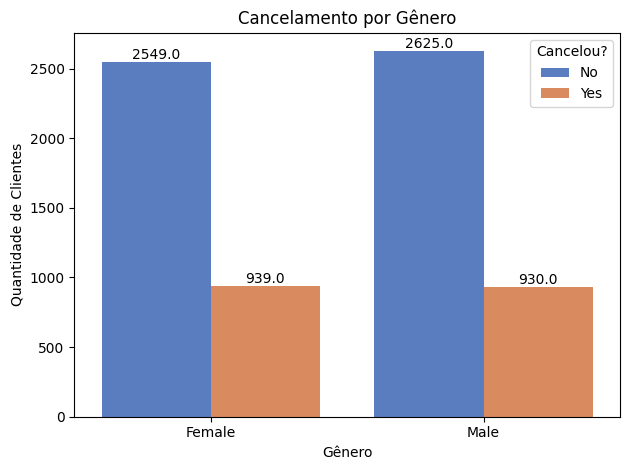

In [86]:
grafico_barra('cliente_genero', 'Cancelamento por Gênero', 'Gênero')

por contrato

In [ ]:
tabela_contrato_cancelamento = df.groupby(['conta_contrato', 'Cancela']).size().unstack()
tabela_contrato_cancelamento
#tabela de cancelamentos por contrato

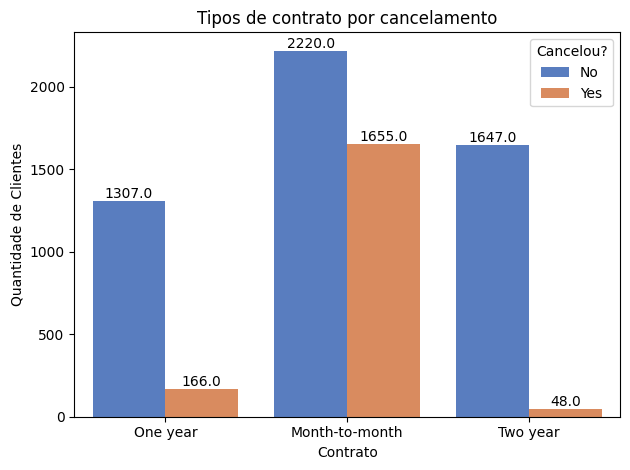

In [90]:
grafico_barra('conta_contrato', 'Tipos de contrato por cancelamento', 'Contrato')

por custo mensal

In [ ]:
tabela_mensal_cancelamento = df.groupby('Cancela')['conta_cobranças_mensais'].mean()
tabela_mensal_cancelamento
#custo mensal por cancelamento

por faixa de valor

In [ ]:
df['faixa_mensal'] = pd.cut(df['conta_cobranças_mensais'], bins=[0, 30, 60, 90, 120], labels=['0-30', '30-60', '60-90', '90-120'])
tabela_faixa_preco_cancelamento = df.groupby(['faixa_mensal', 'Cancela']).size().unstack()
tabela_faixa_preco_cancelamento

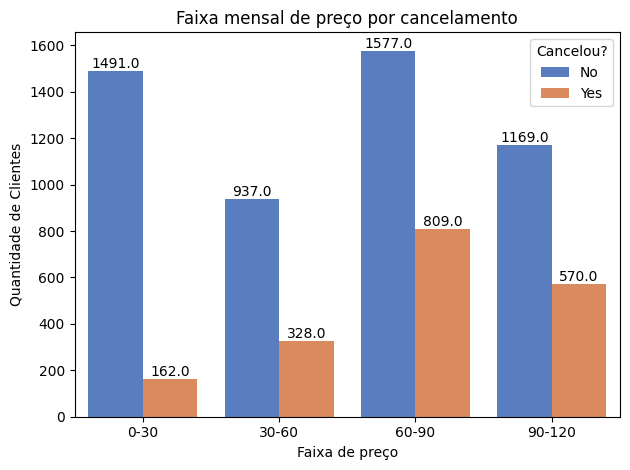

In [91]:
grafico_barra('faixa_mensal', 'Faixa mensal de preço por cancelamento', 'Faixa de preço')

por idades

In [ ]:
tabela_idoso_cancelamento = df.groupby(['cliente_cidadao_senior', 'Cancela']).size().unstack()
tabela_idoso_cancelamento
#tabela de cancelamentos por idade

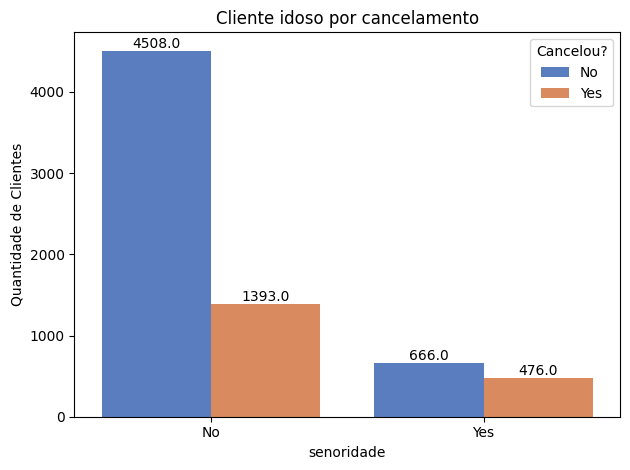

In [92]:
grafico_barra('cliente_cidadao_senior', 'Cliente idoso por cancelamento', 'senoridade')

por serviço

In [152]:
# Lista de serviços
servicos_colunas = [
    'telefone_servico_telefone',
    'telefone_multiplas_linhas',
    'internet_servico_internet',
    'internet_seguranca_online',
    'internet_backup_online',
    'internet_protecao_dispositivo',
    'internet_suporte_tecnico',
    'internet_streaming_tv',
    'internet_streaming_filmes'
]

# Configuração do grid (3 gráficos por linha)
n_cols = 2
n_rows = (len(servicos_colunas) + n_cols - 1) // n_cols

# --- Cria a figura e armazena na variável ---
graficos_servicos = plt.figure(figsize=(16, 5*n_rows))

# Gera cada gráfico
for i, coluna in enumerate(servicos_colunas):
    ax = graficos_servicos.add_subplot(n_rows, n_cols, i+1)
    sns.countplot(data=df, y=coluna, hue='Cancela', palette='Set2', ax=ax)

    ax.set_title(f'Cancelamento por\n{coluna.replace("_", " ").title()}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(title='Cancelou?', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajusta layout e fecha a figura
plt.tight_layout()
plt.close()  # Fecha para não mostrar agora



por forma de pagamento

In [141]:
tabela_pagamento_cancelamento = df.groupby(['conta_metodo_pagamento', 'Cancela']).size().unstack()
tabela_pagamento_cancelamento
#tabela de cancelamentos por idade

Cancela,No,Yes
conta_metodo_pagamento,,
Bank transfer (automatic),1286,258
Credit card (automatic),1290,232
Electronic check,1294,1071
Mailed check,1304,308


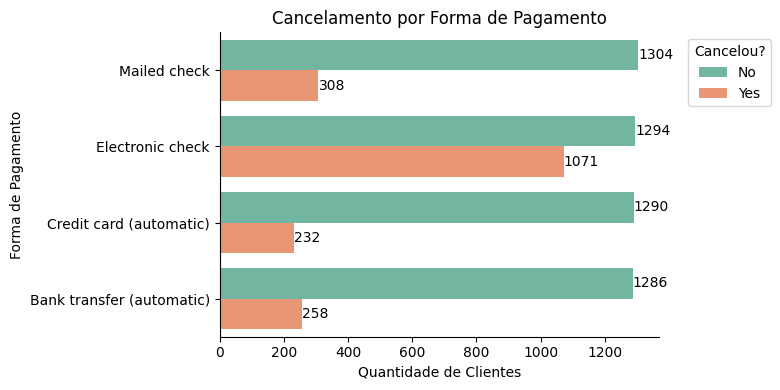

In [129]:
# Cria a figura e o eixo
fig, ax = plt.subplots(figsize=(8, 4))

# Plota o gráfico no eixo criado
sns.countplot(data=df, y='conta_metodo_pagamento', hue='Cancela', palette='Set2', ax=ax)

# Remove as bordas (spines) superior e direita
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adiciona os valores nas barras
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

# Título e eixos
ax.set_title('Cancelamento por Forma de Pagamento')
ax.set_xlabel('Quantidade de Clientes')
ax.set_ylabel('Forma de Pagamento')

# Legenda fora do gráfico à direita
ax.legend(title='Cancelou?', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout() # Ajusta o layout para acomodar a legenda

# Agora você tem a figura armazenada na variável 'fig'
meu_grafico = fig

# Para exibir o gráfico
plt.show()


# Relatório

<h3>Durante o projeto da TelecomX, tendo o foco em identificar possíveis tendências em cancelamentos dos clientes, pude identificar certos padrões:</h3>

Não temos problemas com gêneros dos clientes. Ambos gêneros estão na mesma faixa de cancelamento:

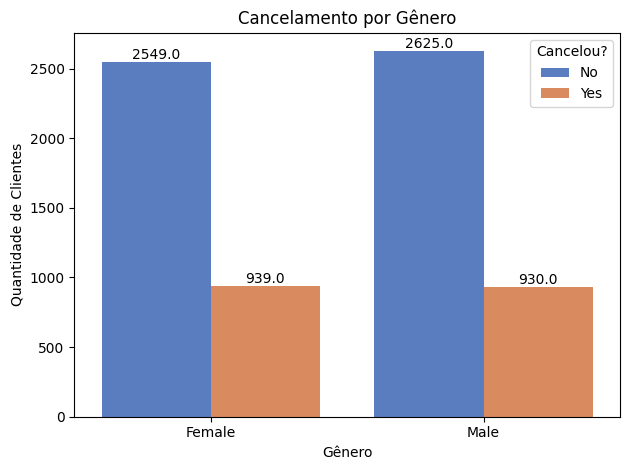

In [115]:
grafico_barra('cliente_genero', 'Cancelamento por Gênero', 'Gênero')

Grande parte dos clientes que evadem são os que assinam planos mensais:

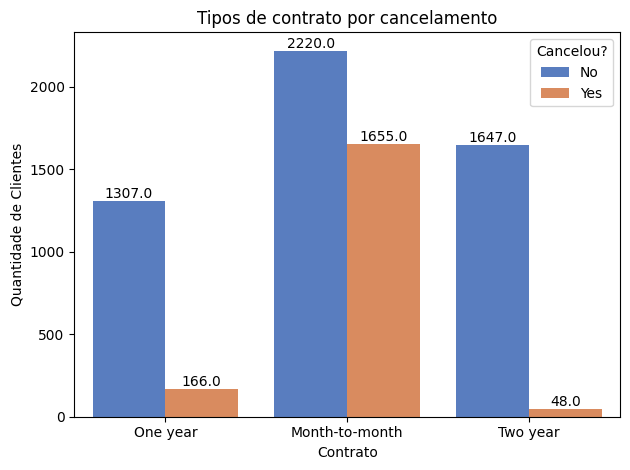

In [116]:
grafico_barra('conta_contrato', 'Tipos de contrato por cancelamento', 'Contrato')

Sobre custos mensais, temos a maioria dos clientes cancelando contratos, com custos entre 60-90. E, logo em seguida os de custo entre (90-120)

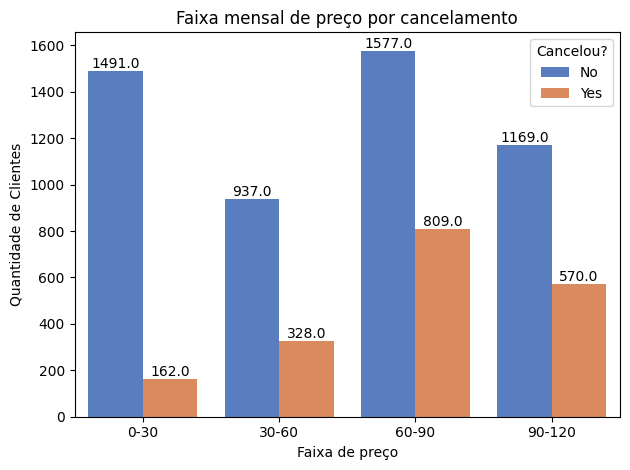

In [117]:
grafico_barra('faixa_mensal', 'Faixa mensal de preço por cancelamento', 'Faixa de preço')

Também indentifiquei que proporcionalmente, clientes idosos tendem a cancelar mais do que os jovens.

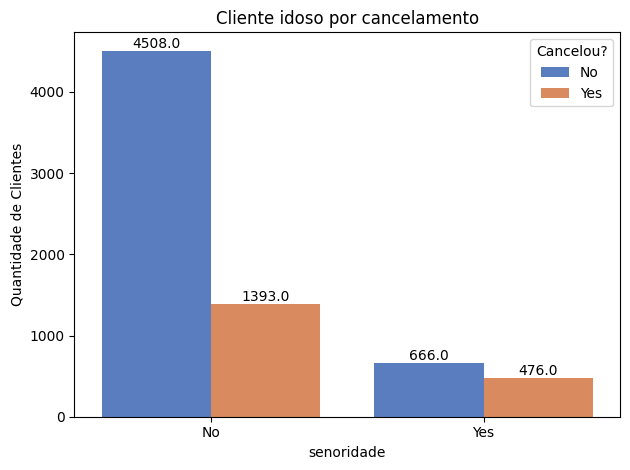

In [118]:
grafico_barra('cliente_cidadao_senior', 'Cliente idoso por cancelamento', 'senoridade')

Sobre as formas de pagamentos, clientes que usam cheques eletrônicos acabam tendo maior vazão

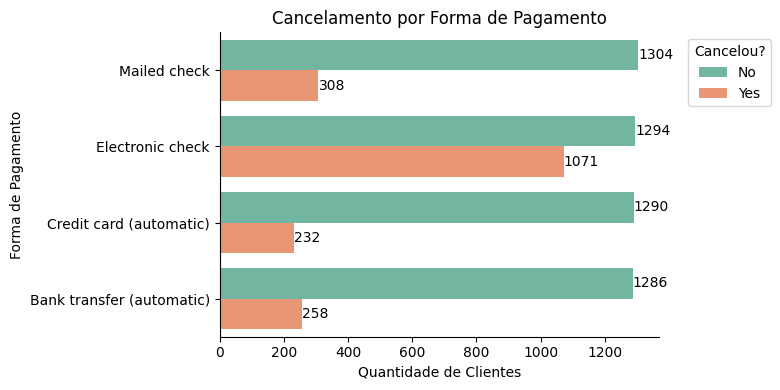

In [130]:
meu_grafico

E por serviços:
* fibra óptica cancelam mais;
* Segurança online cancelam menos;
* com bakup cancelam menos;
* com proteção de dispositivo cancelam menos
* com suporte técnico cancelam menos
 * * outros produtos estão na mesma faixa de cancelamento assinantes e não assinantes


In [ ]:
graficos_servicos

# Sugestões e estratégias:

Sugerimos que façam mais campanhas de marketing para o público jovem, que são nossa maior clientela, e possuem proporcionalmente menos cancelamentos.

Outros pontos sobre descontos e promoções sugeridas

*   Campanhas e promoções para contratos de um ou dois anos
*   No formato de pagamento: cartão de cédito
*   Valores promocionais abaixo de $60

Clientes com produtos assinados tendem a cancelar menos, então é uma ótima ideia propor planos completos aos clientes
